In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from matplotlib import style
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.interpolate import interp1d
# Big plot labels
plt.rcParams.update({'font.size': 14})
# load data frames
df = pd.read_pickle("/Users/kowens2/Documents/SARS-CoV-2 Rebound/PythonNotebooks/NBA_Data_Filtered_With_QuantitativeFeatures.pkl") 
df_regressors = pd.read_pickle(r"/Users/kowens2/Documents/SARS-CoV-2 Rebound/PythonNotebooks/NBA_Data_Filtered_IndividualAttributes.pkl")

### Plot average trajectory stratified by variant.
(1) Filter cases by variant

In [6]:
# Alpha cases
df.loc[df.Lineage == 'B.1.1.7', 'cat_LineageBroad'] = 'Alpha'
# None --> omicron
df.loc[df.cat_LineageBroad == 'None', 'cat_LineageBroad'] = 'Omicron'

df_Other = df[df.cat_LineageBroad == 'Other'].copy()

df_Delta = df[df.cat_LineageBroad == 'Delta'].copy()

df_Omicron = df[df.cat_LineageBroad == 'Omicron'].copy()

df_Alpha = df[df.cat_LineageBroad == 'Alpha'].copy()

(2) Functions for interpolation and plotting. 

In [21]:
def AverageTimeSeriesInterpolation(df, mode='linear'):
# interpolation using input mode within testing range
# append negatives cover range -14 to 50 days if there is a
# negative test at the upper/lower bound of testing
# else append nans which are ignored when calculating the median, and percentiles

    X = np.arange(-14,50)
    neg = 2.6576096821516124;
    for id in list(df.ID.unique()):
        df_id = df[df['ID'] ==id].copy()

        y_interp_1 = interp1d(df_id.time,df_id.y, kind = mode)
        xmin = np.min(df_id.time); 
        xmax = np.max(df_id.time);

        y_tested = y_interp_1(np.arange(xmin,xmax,1))

        if y_tested[0] < 3:
            y_tested = np.concatenate((neg*np.ones((xmin+14)),y_tested ))
            times = np.arange(-14,xmax)
        else:
            temp = np.ones((xmin+14))
            temp[:] = np.nan
            y_tested = np.concatenate((temp,y_tested ))
            times = np.arange(-14,xmax)

        if y_tested[-1] < 3:
            y_tested = np.concatenate((y_tested,neg*np.ones((50-xmax)), ))
            times = np.arange(-14,50)
        else:
            temp = np.ones((50-xmax))
            temp[:] = np.nan
            y_tested = np.concatenate((y_tested,temp))
            times = np.arange(-14,50)

        X = np.vstack((X,y_tested))
    times = X[0,:]
    ppl = X[1:,:]
    return (times,np.nanmedian(ppl, axis = 0),np.nanpercentile(ppl,25,axis=0),np.nanpercentile(ppl,75,axis=0))

def PlotTimeSeries(df, mode ='linear',color='tab:blue',alpha=0.3):
    times, avg, lowp, highp = AverageTimeSeriesInterpolation(df, mode = 3)  
    IDs = df['ID'].unique()
    seaborn.set(style='ticks')
    fig = plt.figure(figsize=(9,5.5), dpi=72, facecolor="white")
    plt.rcParams.update({'font.size': 22})
    axes = plt.subplot(111)
    for i in IDs:
        df_id = df[df['ID'] == i]
        x = df_id.time
        y = df_id.y
        plt.plot(x,y,'.-', color = color, alpha = alpha)

    print('n = ', len(IDs))
    plt.plot(times, np.maximum(avg,2.65), color = 'k', linewidth = '3')
    plt.plot(times[14:], np.maximum(lowp[14:],2.65), color = 'k',linestyle='--')
    plt.plot(times[14:], np.maximum(highp[14:],2.65), color = 'k',linestyle='--')

    plt.ylim((2.5,9.5))
    plt.xlim((-10,20))
    seaborn.despine(ax=axes, offset=10, trim=True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Days relative to detection',fontsize=20,)
    plt.ylabel('log$_{10}$ viral load',fontsize=20)
    fig.tight_layout()
    #plt.savefig('OtherCases.png',bbox_inches='tight', transparent = True)
    plt.show()


n =  177


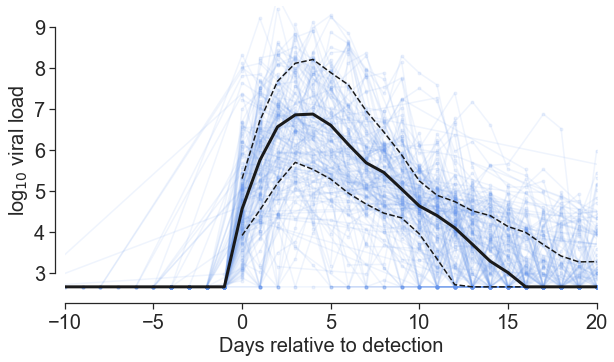

In [22]:
PlotTimeSeries(df_Other, mode =3,color ='cornflowerblue',alpha = 0.1)

n =  46


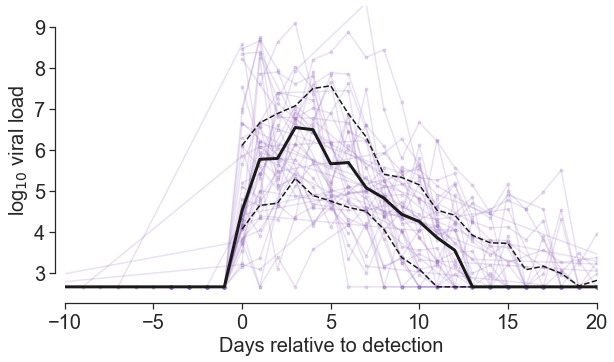

In [24]:
PlotTimeSeries(df_Alpha, mode =3,color = 'tab:purple',  alpha = 0.2)

n =  163


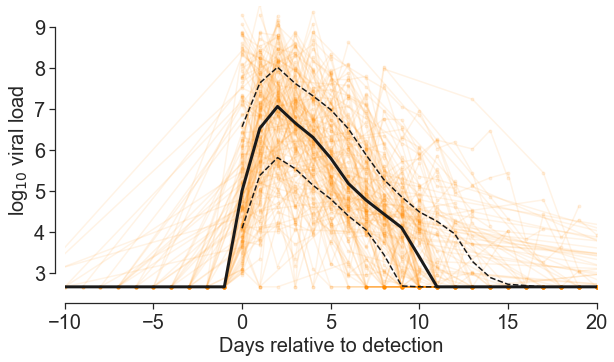

In [23]:
PlotTimeSeries(df_Delta, mode =3,color = 'darkorange', alpha = 0.1)

n =  1124


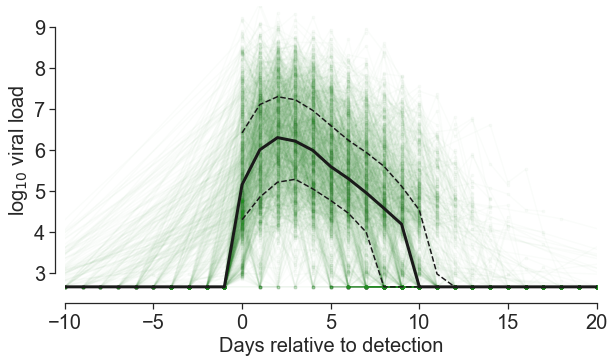

In [25]:
PlotTimeSeries(df_Omicron, mode =3,color = 'forestgreen', alpha = 0.02)

### Additional data besides viral load

In [28]:
# Function for bar charts
def BarChart(df,column, labels, ylimits = [], xlabels = []):
    data = []
    for l in labels:
        percentrows = 100*len(df[df[column]==l])/len(df)
        data.append(percentrows)
        print(np.round(percentrows), '%')
    
    fig = plt.figure(figsize=(4.5,4), dpi=72, facecolor="white")
    if xlabels:
        plt.bar(xlabels, data, facecolor = 'tab:gray')
    else:
        plt.bar(labels, data, facecolor = 'tab:gray')
    if ylimits:
        plt.ylim(ylimits)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    plt.show()

46.0 %
42.0 %
12.0 %


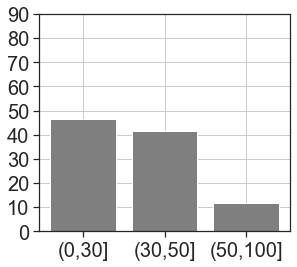

In [30]:
BarChart(df_regressors, 'AgeGroup',['(0,30]', '(30,50]','(50,100]'], ylimits = [0 ,90])

42.0 %
17.0 %
42.0 %


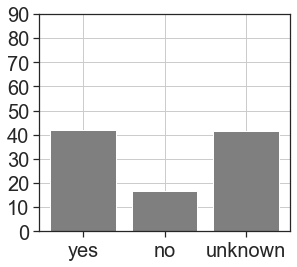

In [32]:
labels = ['Yes','No','Unknown' ]
xlabels = ['yes','no','unknown' ]
BarChart(df_regressors, 'cat_SympEver',labels,xlabels=xlabels, ylimits = [0 ,90])

19.0 %
10.0 %
30.0 %
40.0 %


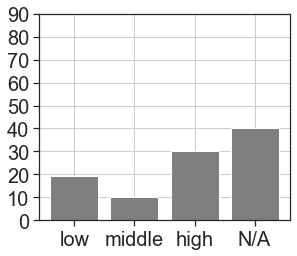

In [35]:
# For titer group we want the nans to be N/A, 
labels = ['(-1,125]','(125,250]','(250,1e+03]']
data = []
for l in labels:
    percentrows = 100*len(df_regressors[df_regressors['TiterGroup']==l])/len(df_regressors)
    data.append(percentrows)
    print(np.round(percentrows), '%')
print(np.round(100-np.sum(data)), '%')
data.append(100-np.sum(data))
fig = plt.figure(figsize=(4.5,3.8), dpi=72, facecolor="white")
plt.bar(['low','middle','high', 'N/A' ], data, facecolor = 'tab:gray')
plt.ylim([0 ,90])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()

94.0 %
6.0 %


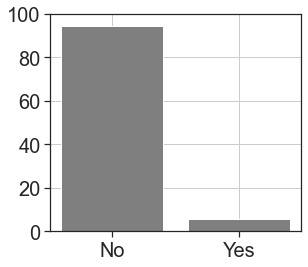

In [31]:
BarChart(df_regressors, 'cat_Rebound',[0,1],xlabels=['No','Yes' ], ylimits = [0 ,100])

73.0 %
17.0 %
10.0 %


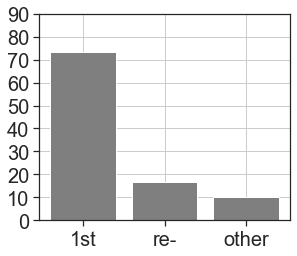

In [36]:
# For primary infection vs. other, we want to group all other diagnoses
labels = [ 'Confirmed Positive','Confirmed Reinfection']
data = []
for l in labels:
    percentrows = 100*len(df_regressors[df_regressors['cat_Diagnosis']==l])/len(df_regressors)
    data.append(percentrows)
    print(np.round(percentrows), '%')
percentrows = 100*len(df_regressors[(df_regressors['cat_Diagnosis']!=labels[0])*(df_regressors['cat_Diagnosis']!=labels[1])])/len(df_regressors)
data.append(percentrows)
print(np.round(percentrows), '%')
fig = plt.figure(figsize=(4.5,3.8), dpi=72, facecolor="white")
plt.bar(['1st','re-', 'other'], data, facecolor = 'tab:gray')
plt.ylim([0 ,90])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()

Bubble plot showing correlation between variant and vaccination status.

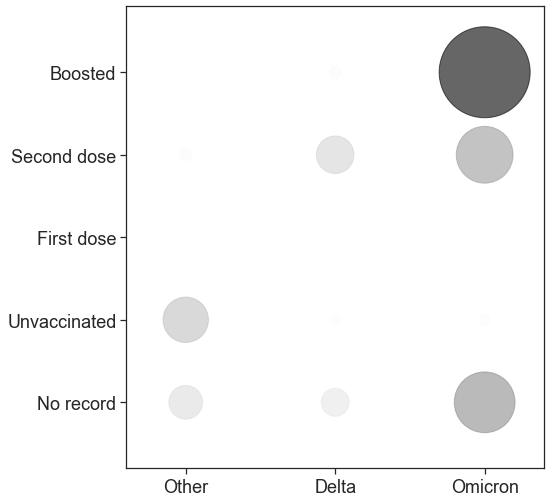

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 16})

x,y = np.meshgrid(['Other', 'Delta', 'Omicron'], ['No record','Unvaccinated', 'First dose', 'Second dose', 'Boosted'])
counts = []
for (lineage, status) in zip(x.flatten(),y.flatten()):
    count = len(df_regressors[(df_regressors['cat_LineageBroad'] == lineage)*(df_regressors['cat_VaccStatus'] == status)])
    counts.append(count)

fig, ax = plt.subplots(figsize = (7.5,8.5))
cb = ax.scatter(x = x.flatten(), y = y.flatten(), s = 15*np.array(counts), c = counts, cmap=cm.gray_r, alpha = 0.6)
ax.margins(.2)
ax.tick_params(axis='both', which='major', labelsize=18)
#cb = fig.colorbar(cb, ax = ax)
#cb.set_label('Number of infections',size = 16)
#cb.ax.tick_params(labelsize=14)
plt.show()

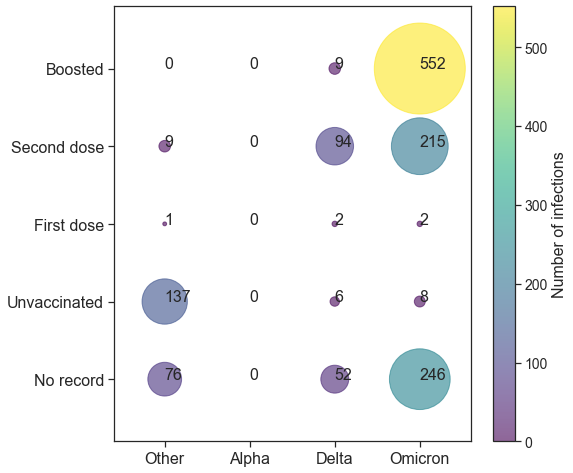

In [39]:
# print the number of infections out
x,y = np.meshgrid(['Other','Alpha', 'Delta', 'Omicron'], ['No record','Unvaccinated', 'First dose', 'Second dose', 'Boosted'])
counts = []
for (lineage, status) in zip(x.flatten(),y.flatten()):
    count = len(df_regressors[(df_regressors['cat_LineageBroad'] == lineage)*(df_regressors['cat_VaccStatus'] == status)])
    counts.append(count)

fig, ax = plt.subplots(figsize = (8,8))
cb = ax.scatter(x = x.flatten(), y = y.flatten(), s = 15*np.array(counts), c = counts, cmap=cm.viridis, alpha = 0.6)
ax.margins(.2)
ax.tick_params(axis='both', which='major', labelsize=16)
cb = fig.colorbar(cb, ax = ax)
cb.set_label('Number of infections',size = 16)
cb.ax.tick_params(labelsize=14)
for ii,(i,j) in enumerate(zip(x.flatten(),y.flatten())):
    ax.annotate(str(counts[ii]),xy=(i,j))

plt.show()


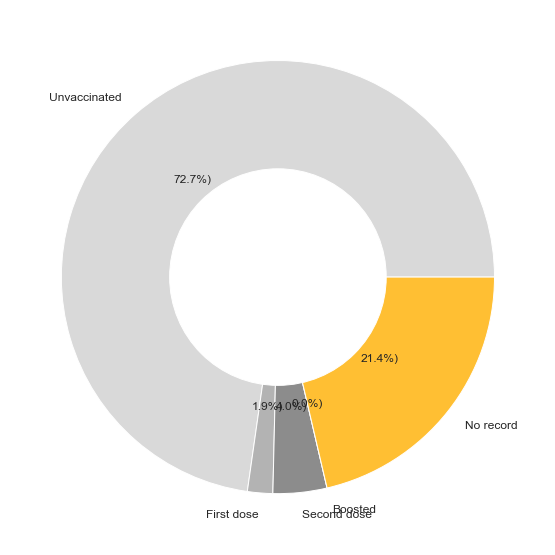

In [40]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%)".format(pct, absolute)

labels = ['Unvaccinated', 'First dose', 'Second dose', 'Boosted', 'No record']
colors = [(0.85, 0.85, 0.85), (.7,.7,.7), (.55,.55,.55), (.4,.4,.4),(1,.75,.2)]

data = []
for l in labels:
    percentrows = len(df_Other[df_Other['cat_VaccStatus']==l])
    data.append(percentrows)
    
fig = plt.figure(figsize=(8,8), dpi=72, facecolor="white")
plt.pie(data, colors = colors,autopct = lambda pct: func(pct, data), labels = [str(x) for x in labels],textprops={'fontsize': 12})
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
#plt.savefig('OtherVaccStatus.png',bbox_inches='tight', transparent = True)



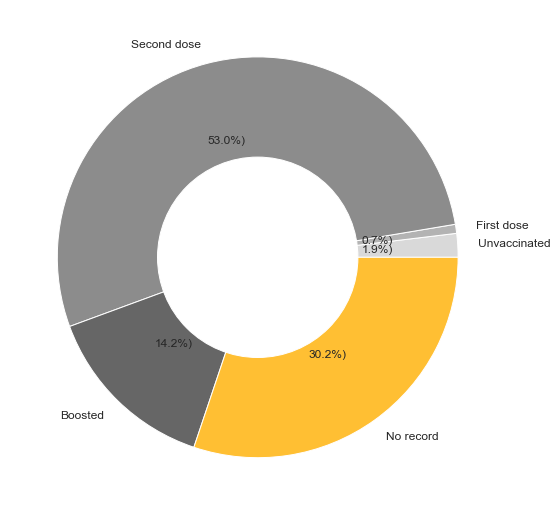

In [41]:
# Pie chart of vaccination status by variant

data = []
for l in labels:
    percentrows = len(df_Delta[df_Delta['cat_VaccStatus']==l])
    data.append(percentrows)

fig = plt.figure(figsize=(8,8), dpi=72, facecolor="white")
plt.pie(data, colors = colors,autopct = lambda pct: func(pct, data), labels = [str(x) for x in labels],textprops={'fontsize': 12})
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()

#plt.savefig('DeltaVaccStatus.png',bbox_inches='tight', transparent = True)

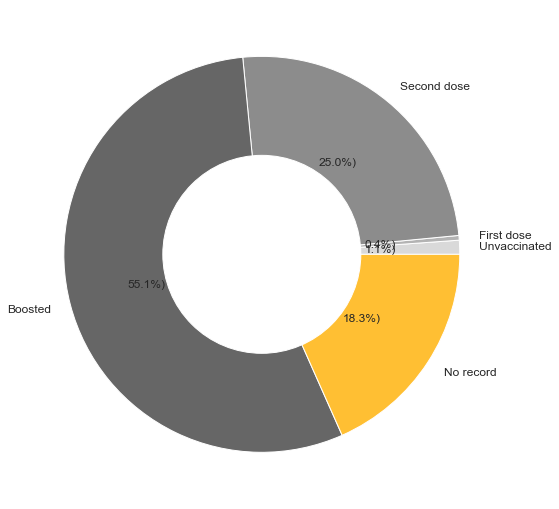

In [42]:
data = []
for l in labels:
    percentrows = len(df_Omicron[df_Omicron['cat_VaccStatus']==l])
    data.append(percentrows)
    
fig = plt.figure(figsize=(8,8), dpi=72, facecolor="white")
plt.pie(data, colors = colors,autopct = lambda pct: func(pct, data), labels = [str(x) for x in labels],textprops={'fontsize': 12})
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
#plt.savefig('OmicronVaccStatus.png',bbox_inches='tight', transparent = True)

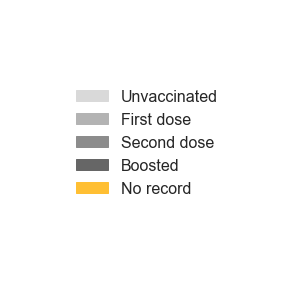

In [43]:
# Create legend 
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
labels = ['Unvaccinated', 'First dose', 'Second dose', 'Boosted', 'No record']
colors = [(0.85, 0.85, 0.85), (.7,.7,.7), (.55,.55,.55), (.4,.4,.4),(1,.75,.2)]


fig, ax = plt.subplots(figsize=(5,5))
handles = [mpatches.Patch(color=c, label=l) for (c,l) in zip(colors, labels)]
ax.legend(handles=handles, loc = 'center', frameon=False, fontsize = 16)
plt.axis('off')
plt.show()